In [155]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [156]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgbm
import gc
import xgboost as xgb

In [157]:
items           = pd.read_csv('items.csv')
item_categories = pd.read_csv('item_categories.csv')
shops           = pd.read_csv('shops.csv')
sales_train     = pd.read_csv('sales_train_v2.csv')
test            = pd.read_csv('test.csv')
sample_submission            = pd.read_csv('sample_submission.csv')

In [158]:
transactions = sales_train.copy()
transactions[['day','month', 'year']] = transactions['date'].str.split('.', expand=True).astype(int)


In [159]:
w_cat_ids = transactions.set_index('item_id').join(items.set_index('item_id'))
w_cat_ids = w_cat_ids.reset_index()
w_cat_ids['row_id'] = w_cat_ids.index
w_cat_ids['y'] = w_cat_ids.groupby(['date_block_num', 'item_id', 'shop_id'])['item_cnt_day'].transform('sum').clip(0,20)
w_cat_ids = w_cat_ids.drop_duplicates(['date_block_num', 'item_id', 'shop_id'])
w_cat_ids = w_cat_ids[w_cat_ids['year'] != 2013]


In [160]:
w_cat_ids['item_mean'] = w_cat_ids.groupby(['item_id'])['y'].transform('mean')
w_cat_ids['item_mean_month'] = w_cat_ids.groupby(['item_id', 'month'])['y'].transform('mean')
w_cat_ids['shop_mean_month'] = w_cat_ids.groupby(['shop_id', 'month'])['y'].transform('mean')
w_cat_ids['category_mean_month'] = w_cat_ids.groupby(['item_category_id', 'month'])['y'].transform('mean')
w_cat_ids['shop_category_mean_month'] = w_cat_ids.groupby(['shop_id','item_category_id', 'month'])['y'].transform('mean')

In [161]:
X = w_cat_ids[(w_cat_ids['year'] == 2015) | ((w_cat_ids['year'] == 2014) & (w_cat_ids['month'].isin([11,12])))]

In [162]:
rollings = X[['item_mean_month', 'date_block_num', 'item_id']].copy()
rollings = rollings.drop_duplicates(['item_id', 'date_block_num'])
rollings = rollings.set_index(['date_block_num', 'item_id'])
a = rollings.sort_values(['item_id', 'date_block_num'])\
        .groupby(['item_id'])['item_mean_month'].shift(1)
aa = rollings.sort_values(['item_id', 'date_block_num'])\
        .groupby(['item_id'])['item_mean_month'].shift(3)
aaa = rollings.sort_values(['item_id', 'date_block_num'])\
        .groupby(['item_id'])['item_mean_month'].shift(6)

In [163]:
b = pd.DataFrame(a)
b.rename(columns={'item_mean_month': 'item_mean_month_minus_1'}, inplace=True)

X = pd.merge(X, b, on=['item_id', 'date_block_num'], how='left')

In [164]:
b = pd.DataFrame(aa)
b.rename(columns={'item_mean_month': 'item_mean_month_minus_3'}, inplace=True)

X = pd.merge(X, b, on=['item_id', 'date_block_num'], how='left')

In [165]:
b = pd.DataFrame(aaa)
b.rename(columns={'item_mean_month': 'item_mean_month_minus_6'}, inplace=True)

X = pd.merge(X, b, on=['item_id', 'date_block_num'], how='left')

In [166]:
rollings = X[['shop_mean_month', 'date_block_num', 'shop_id']].copy()
rollings = rollings.drop_duplicates(['shop_id', 'date_block_num'])
rollings = rollings.set_index(['date_block_num', 'shop_id'])
a = rollings.sort_values(['shop_id', 'date_block_num'])\
        .groupby(['shop_id'])['shop_mean_month'].shift(1)
aa = rollings.sort_values(['shop_id', 'date_block_num'])\
        .groupby(['shop_id'])['shop_mean_month'].shift(3)
aaa = rollings.sort_values(['shop_id', 'date_block_num'])\
        .groupby(['shop_id'])['shop_mean_month'].shift(6)

In [167]:
b = pd.DataFrame(a)
b.rename(columns={'shop_mean_month': 'shop_mean_month_minus_1'}, inplace=True)

X = pd.merge(X, b, on=['shop_id', 'date_block_num'], how='left')

In [168]:
b = pd.DataFrame(aa)
b.rename(columns={'shop_mean_month': 'shop_mean_month_minus_3'}, inplace=True)

X = pd.merge(X, b, on=['shop_id', 'date_block_num'], how='left')

In [169]:
b = pd.DataFrame(aaa)
b.rename(columns={'shop_mean_month': 'shop_mean_month_minus_6'}, inplace=True)

X = pd.merge(X, b, on=['shop_id', 'date_block_num'], how='left')

In [170]:
rollings = X[['category_mean_month', 'date_block_num', 'item_category_id']].copy()
rollings = rollings.drop_duplicates(['item_category_id', 'date_block_num'])
rollings = rollings.set_index(['date_block_num', 'item_category_id'])
a = rollings.sort_values(['item_category_id', 'date_block_num'])\
        .groupby(['item_category_id'])['category_mean_month'].shift(1)
aa = rollings.sort_values(['item_category_id', 'date_block_num'])\
        .groupby(['item_category_id'])['category_mean_month'].shift(3)
aaa = rollings.sort_values(['item_category_id', 'date_block_num'])\
        .groupby(['item_category_id'])['category_mean_month'].shift(6)

In [171]:
b = pd.DataFrame(a)
b.rename(columns={'category_mean_month': 'category_mean_month_minus_1'}, inplace=True)

X = pd.merge(X, b, on=['item_category_id', 'date_block_num'], how='left')

In [172]:
b = pd.DataFrame(aa)
b.rename(columns={'category_mean_month': 'category_mean_month_minus_3'}, inplace=True)

X = pd.merge(X, b, on=['item_category_id', 'date_block_num'], how='left')

In [173]:
b = pd.DataFrame(aaa)
b.rename(columns={'category_mean_month': 'category_mean_month_minus_6'}, inplace=True)

X = pd.merge(X, b, on=['item_category_id', 'date_block_num'], how='left')

In [174]:
rollings = X[['shop_category_mean_month', 'date_block_num', 'shop_id', 'item_category_id']].copy()
rollings = rollings.drop_duplicates(['item_category_id', 'shop_id', 'date_block_num'])
rollings = rollings.set_index(['date_block_num', 'item_category_id', 'shop_id'])
a = rollings.sort_values(['item_category_id', 'shop_id', 'date_block_num'])\
        .groupby(['item_category_id', 'shop_id'])['shop_category_mean_month'].shift(1)
aa = rollings.sort_values(['item_category_id', 'shop_id', 'date_block_num'])\
        .groupby(['item_category_id', 'shop_id'])['shop_category_mean_month'].shift(3)
aaa = rollings.sort_values(['item_category_id', 'shop_id', 'date_block_num'])\
        .groupby(['item_category_id', 'shop_id'])['shop_category_mean_month'].shift(6)

In [175]:
b = pd.DataFrame(a)
b.rename(columns={'shop_category_mean_month': 'shop_category_mean_month_minus_1'}, inplace=True)

X = pd.merge(X, b, on=['item_category_id', 'shop_id', 'date_block_num'], how='left')

In [176]:
b = pd.DataFrame(aa)
b.rename(columns={'shop_category_mean_month': 'shop_category_mean_month_minus_3'}, inplace=True)

X = pd.merge(X, b, on=['item_category_id', 'shop_id', 'date_block_num'], how='left')

In [177]:
b = pd.DataFrame(aaa)
b.rename(columns={'shop_category_mean_month': 'shop_category_mean_month_minus_6'}, inplace=True)

X = pd.merge(X, b, on=['item_category_id', 'shop_id', 'date_block_num'], how='left')

In [178]:
X[X['item_id'] == 30].drop_duplicates(['item_id', 'date_block_num'])[['item_id', 'month', 'year', 'item_mean_month', 'item_mean_month_minus_1', 'item_mean_month_minus_3', 'item_mean_month_minus_6']]

,item_id,month,year,item_mean_month,item_mean_month_minus_1,item_mean_month_minus_3,item_mean_month_minus_6
10,30,11,2014,1.300000,NaN,NaN,NaN
20,30,12,2014,1.600000,1.300000,NaN,NaN
30,30,1,2015,1.894737,1.600000,NaN,NaN
41,30,2,2015,1.266667,1.894737,1.300000,NaN
53,30,3,2015,1.714286,1.266667,1.600000,NaN
58,30,4,2015,1.388889,1.714286,1.894737,NaN
62,30,5,2015,1.235294,1.388889,1.266667,1.300000
66,30,6,2015,1.133333,1.235294,1.714286,1.600000
70,30,7,2015,1.214286,1.133333,1.388889,1.894737
73,30,8,2015,1.285714,1.214286,1.235294,1.266667


In [179]:
X[X['shop_id'] == 30].drop_duplicates(['shop_id', 'date_block_num'])[['shop_id', 'month', 'year', 'shop_mean_month', 'shop_mean_month_minus_1', 'shop_mean_month_minus_3', 'shop_mean_month_minus_6']]

,shop_id,month,year,shop_mean_month,shop_mean_month_minus_1,shop_mean_month_minus_3,shop_mean_month_minus_6
11,30,11,2014,1.873958,NaN,NaN,NaN
35,30,1,2015,1.736099,2.118103,NaN,NaN
130,30,2,2015,1.670232,1.736099,1.873958,NaN
245,30,12,2014,2.118103,1.873958,NaN,NaN


In [180]:
X[X['item_category_id'] == 30].drop_duplicates(['item_category_id', 'date_block_num'])[['item_category_id', 'month', 'year', 'category_mean_month', 'category_mean_month_minus_1']]

,item_category_id,month,year,category_mean_month,category_mean_month_minus_1
3762,30,10,2015,3.070205,2.746511
11027,30,1,2015,3.009862,3.101948
11028,30,7,2015,2.670056,2.788012
12837,30,11,2014,2.843284,NaN
12854,30,12,2014,3.101948,2.843284
12897,30,2,2015,2.905608,3.009862
12904,30,3,2015,2.889822,2.905608
12913,30,4,2015,2.892322,2.889822
12925,30,5,2015,2.702312,2.892322
12933,30,6,2015,2.788012,2.702312


In [181]:
X[(X['item_category_id'] == 30) & (X['shop_id'] == 30)].drop_duplicates(['item_category_id', 'shop_id', 'date_block_num'])[['item_category_id', 'shop_id' ,  'month', 'year', 'shop_category_mean_month', 'shop_category_mean_month_minus_1']]

,item_category_id,shop_id,month,year,shop_category_mean_month,shop_category_mean_month_minus_1
16939,30,30,11,2014,1.864198,NaN
16992,30,30,12,2014,2.421687,1.864198
17043,30,30,1,2015,2.597633,2.421687
17087,30,30,2,2015,2.488550,2.597633


In [182]:
X.columns

Index(['item_id', 'date', 'date_block_num', 'shop_id', 'item_price',
       'item_cnt_day', 'day', 'month', 'year', 'item_name', 'item_category_id',
       'row_id', 'y', 'item_mean', 'item_mean_month', 'shop_mean_month',
       'category_mean_month', 'shop_category_mean_month',
       'item_mean_month_minus_1', 'item_mean_month_minus_3',
       'item_mean_month_minus_6', 'shop_mean_month_minus_1',
       'shop_mean_month_minus_3', 'shop_mean_month_minus_6',
       'category_mean_month_minus_1', 'category_mean_month_minus_3',
       'category_mean_month_minus_6', 'shop_category_mean_month_minus_1',
       'shop_category_mean_month_minus_3', 'shop_category_mean_month_minus_6'],
      dtype='object')

In [183]:
columns = X.columns
percent_missing = X.isna().sum() * 100 / len(X)
pd.DataFrame({'column_name': columns,
                                 'percent_missing': percent_missing})

,column_name,percent_missing
item_id,item_id,0.000000
date,date,0.000000
date_block_num,date_block_num,0.000000
shop_id,shop_id,0.000000
item_price,item_price,0.000000
item_cnt_day,item_cnt_day,0.000000
day,day,0.000000
month,month,0.000000
year,year,0.000000
item_name,item_name,0.000000


In [184]:
test_w_cat_ids = test.set_index('item_id').join(items.set_index('item_id'))
test_w_cat_ids['item_id'] = test_w_cat_ids.index

In [185]:
#features = ['item_id', 'date_block_num', 'shop_id', #'item_price',
            features = ['item_id', 'shop_id',  'month', 'item_category_id',
       'item_mean', 'item_mean_month', 'shop_mean_month',
       'category_mean_month', 'shop_category_mean_month',
       'item_mean_month_minus_1', 'item_mean_month_minus_3',
       'item_mean_month_minus_6', 'shop_mean_month_minus_1',
       'shop_mean_month_minus_3', 'shop_mean_month_minus_6',
       'category_mean_month_minus_1', 'category_mean_month_minus_3',
       'category_mean_month_minus_6', 'shop_category_mean_month_minus_1',
       'shop_category_mean_month_minus_3', 'shop_category_mean_month_minus_6']

In [186]:
val_indices = X[(X['year'] == 2015) & (X['month'].isin([9,10]))].index

In [187]:
X[features].head()

,item_id,shop_id,month,item_category_id,item_mean,item_mean_month,shop_mean_month,category_mean_month,shop_category_mean_month,item_mean_month_minus_1,...,item_mean_month_minus_6,shop_mean_month_minus_1,shop_mean_month_minus_3,shop_mean_month_minus_6,category_mean_month_minus_1,category_mean_month_minus_3,category_mean_month_minus_6,shop_category_mean_month_minus_1,shop_category_mean_month_minus_3,shop_category_mean_month_minus_6
0,2,54,11,40,1.0,1.0,2.355769,1.765038,2.322449,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5,54,12,40,1.0,1.0,2.775493,2.074243,2.550369,NaN,...,NaN,2.355769,NaN,NaN,1.765038,NaN,NaN,2.322449,NaN,NaN
2,7,54,12,40,1.0,1.0,2.775493,2.074243,2.550369,NaN,...,NaN,2.355769,NaN,NaN,1.765038,NaN,NaN,2.322449,NaN,NaN
3,10,54,1,40,1.0,1.0,2.479937,1.865802,2.482730,NaN,...,NaN,2.775493,NaN,NaN,2.074243,NaN,NaN,2.550369,NaN,NaN
4,11,54,11,40,1.0,1.0,2.355769,1.765038,2.322449,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [188]:
x = X[features] 
y = X['y']


x_train = x[~x.index.isin(val_indices)]
y_train = y[~y.index.isin(val_indices)]

x_val = x[x.index.isin(val_indices)]
y_val = y[y.index.isin(val_indices)]

In [189]:
lgtrain = lgbm.Dataset(x_train, label=y_train, categorical_feature=[0,1,2,3])
lgval = lgbm.Dataset(x_val, label=y_val, categorical_feature=[0,1,2,3])



#[0.00542047893814942, 29, 24, 0.39949465609514856, 1, 0.67943500, 10]
params = {
        "num_threads": 8,
        "verbosity": -1,
        #"zero_as_missing": "true",
        "boosting":'gbdt',
        "objective" : "regression",
        "metric" : "rmse",
        "seed": 42,
        #"max_bin": 10,
        #"num_leaves": 10,
        "bagging_fraction": 0.2,
        "bagging_freq": 1,
        "min_data_in_leaf": 5000,
        "feature_fraction": 0.5,
        #"lambda_l2": 3,
        #"max_depth": 2,
        "learning_rate" : 0.01
}

evals_result = {}
model_lgb = lgbm.train(params, lgtrain, 50000, 
                      valid_sets=[lgval], 
                      early_stopping_rounds=100, 
                      verbose_eval=500, 
                      evals_result=evals_result)

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[500]	valid_0's rmse: 1.89959
[1000]	valid_0's rmse: 1.81591
[1500]	valid_0's rmse: 1.77296
[2000]	valid_0's rmse: 1.74656
[2500]	valid_0's rmse: 1.72778
[3000]	valid_0's rmse: 1.71395
[3500]	valid_0's rmse: 1.70336
[4000]	valid_0's rmse: 1.69439
[4500]	valid_0's rmse: 1.68753
[5000]	valid_0's rmse: 1.68189
[5500]	valid_0's rmse: 1.67658
[6000]	valid_0's rmse: 1.67253
[6500]	valid_0's rmse: 1.66847
[7000]	valid_0's rmse: 1.66506
[7500]	valid_0's rmse: 1.66217
[8000]	valid_0's rmse: 1.65976
[8500]	valid_0's rmse: 1.65708
[9000]	valid_0's rmse: 1.65456
[9500]	valid_0's rmse: 1.65229
[10000]	valid_0's rmse: 1.65049
[10500]	valid_0's rmse: 1.64891
[11000]	valid_0's rmse: 1.64716
[11500]	valid_0's rmse: 1.64567
[12000]	valid_0's rmse: 1.64388
Early stopping, best iteration is:
[12009]	valid_0's rmse: 1.64382


In [191]:
test_w_cat_ids = test.set_index('item_id').join(items.set_index('item_id'))
test_w_cat_ids['item_id'] = test_w_cat_ids.index

In [192]:
test_w_cat_ids['month'] = 11

In [193]:
item_level = X.drop_duplicates(['item_id'])[['item_id','item_mean', 'item_price']]

test_w_cat_ids = pd.merge(test_w_cat_ids, item_level, on=['item_id'], how='left')

In [194]:
item_month_level = X[(X.month == 11)].drop_duplicates(['item_id'])[['item_id','item_mean_month']]

test_w_cat_ids = pd.merge(test_w_cat_ids, item_month_level, on=['item_id'], how='left')

In [195]:
item_month_level_ = X[X.month == 10].drop_duplicates(['item_id'])[['item_id','item_mean_month']]\
                                   .copy().rename(columns={'item_mean_month':'item_mean_month_minus_1'})


test_w_cat_ids = pd.merge(test_w_cat_ids, item_month_level_, on=['item_id'], how='left')

In [196]:
item_month_level_ = X[X.month == 8].drop_duplicates(['item_id'])[['item_id','item_mean_month']]\
                                   .copy().rename(columns={'item_mean_month':'item_mean_month_minus_3'})


test_w_cat_ids = pd.merge(test_w_cat_ids, item_month_level_, on=['item_id'], how='left')

In [197]:
item_month_level_ = X[X.month == 5].drop_duplicates(['item_id'])[['item_id','item_mean_month']]\
                                   .copy().rename(columns={'item_mean_month':'item_mean_month_minus_6'})


test_w_cat_ids = pd.merge(test_w_cat_ids, item_month_level_, on=['item_id'], how='left')

In [198]:
shop_month_level_ = X[(X.month == 11)].drop_duplicates(['shop_id'])[['shop_id','shop_mean_month']]

test_w_cat_ids = pd.merge(test_w_cat_ids, shop_month_level_, on=['shop_id'], how='left')

In [199]:
shop_month_level_ = X[X.month == 10].drop_duplicates(['shop_id'])[['shop_id','shop_mean_month']]\
                                   .copy().rename(columns={'shop_mean_month':'shop_mean_month_minus_1'})


test_w_cat_ids = pd.merge(test_w_cat_ids, shop_month_level_, on=['shop_id'], how='left')

In [200]:
shop_month_level_ = X[X.month == 8].drop_duplicates(['shop_id'])[['shop_id','shop_mean_month']]\
                                   .copy().rename(columns={'shop_mean_month':'shop_mean_month_minus_3'})


test_w_cat_ids = pd.merge(test_w_cat_ids, shop_month_level_, on=['shop_id'], how='left')

In [201]:
shop_month_level_ = X[X.month == 5].drop_duplicates(['shop_id'])[['shop_id','shop_mean_month']]\
                                   .copy().rename(columns={'shop_mean_month':'shop_mean_month_minus_6'})


test_w_cat_ids = pd.merge(test_w_cat_ids, shop_month_level_, on=['shop_id'], how='left')

In [202]:
cat_month_level_ = X[(X.month == 11)].drop_duplicates(['item_category_id'])[['item_category_id','category_mean_month']]

test_w_cat_ids = pd.merge(test_w_cat_ids, cat_month_level_, on=['item_category_id'], how='left')

In [203]:
cat_month_level_ = X[X.month == 10].drop_duplicates(['item_category_id'])[['item_category_id','category_mean_month']]\
                                   .copy().rename(columns={'category_mean_month':'category_mean_month_minus_1'})


test_w_cat_ids = pd.merge(test_w_cat_ids, cat_month_level_, on=['item_category_id'], how='left')

In [204]:
cat_month_level_ = X[X.month == 8].drop_duplicates(['item_category_id'])[['item_category_id','category_mean_month']]\
                                   .copy().rename(columns={'category_mean_month':'category_mean_month_minus_3'})


test_w_cat_ids = pd.merge(test_w_cat_ids, cat_month_level_, on=['item_category_id'], how='left')

In [205]:
cat_month_level_ = X[X.month == 5].drop_duplicates(['item_category_id'])[['item_category_id','category_mean_month']]\
                                   .copy().rename(columns={'category_mean_month':'category_mean_month_minus_6'})


test_w_cat_ids = pd.merge(test_w_cat_ids, cat_month_level_, on=['item_category_id'], how='left')

In [206]:
shop_cat_month_level_ = X[(X.month == 11)].drop_duplicates(['item_category_id', 'shop_id'])[['item_category_id', 'shop_id', 'shop_category_mean_month']]

test_w_cat_ids = pd.merge(test_w_cat_ids, shop_cat_month_level_, on=['item_category_id', 'shop_id'], how='left')

In [207]:
shop_cat_month_level_ = X[X.month == 10].drop_duplicates(['item_category_id', 'shop_id'])[['item_category_id', 'shop_id', 'shop_category_mean_month']]\
                                   .copy().rename(columns={'shop_category_mean_month':'shop_category_mean_month_minus_1'})


test_w_cat_ids = pd.merge(test_w_cat_ids, shop_cat_month_level_, on=['item_category_id', 'shop_id'], how='left')

In [208]:
shop_cat_month_level_ = X[X.month == 8].drop_duplicates(['item_category_id', 'shop_id'])[['item_category_id', 'shop_id', 'shop_category_mean_month']]\
                                   .copy().rename(columns={'shop_category_mean_month':'shop_category_mean_month_minus_3'})


test_w_cat_ids = pd.merge(test_w_cat_ids, shop_cat_month_level_, on=['item_category_id', 'shop_id'], how='left')

In [209]:
shop_cat_month_level_ = X[X.month == 5].drop_duplicates(['item_category_id', 'shop_id'])[['item_category_id', 'shop_id', 'shop_category_mean_month']]\
                                   .copy().rename(columns={'shop_category_mean_month':'shop_category_mean_month_minus_6'})


test_w_cat_ids = pd.merge(test_w_cat_ids, shop_cat_month_level_, on=['item_category_id', 'shop_id'], how='left')

In [210]:
test_w_cat_ids[features].head()

,item_id,shop_id,month,item_category_id,item_mean,item_mean_month,shop_mean_month,category_mean_month,shop_category_mean_month,item_mean_month_minus_1,...,item_mean_month_minus_6,shop_mean_month_minus_1,shop_mean_month_minus_3,shop_mean_month_minus_6,category_mean_month_minus_1,category_mean_month_minus_3,category_mean_month_minus_6,shop_category_mean_month_minus_1,shop_category_mean_month_minus_3,shop_category_mean_month_minus_6
0,30,5,11,40,1.447115,1.3,1.767978,1.765038,1.342282,1.555556,...,1.235294,1.688486,1.686054,1.634810,1.713469,1.734725,1.684363,1.446903,1.328076,1.251121
1,30,4,11,40,1.447115,1.3,1.879365,1.765038,1.129032,1.555556,...,1.235294,1.618246,1.631619,1.659556,1.713469,1.734725,1.684363,1.270270,1.213930,1.152284
2,30,6,11,40,1.447115,1.3,2.093153,1.765038,1.603774,1.555556,...,1.235294,1.927950,1.728078,1.739070,1.713469,1.734725,1.684363,1.446328,1.392473,1.374631
3,30,3,11,40,1.447115,1.3,1.865922,1.765038,1.421053,1.555556,...,1.235294,1.657799,1.694631,1.561497,1.713469,1.734725,1.684363,1.279661,1.218310,1.187970
4,30,2,11,40,1.447115,1.3,2.282407,1.765038,1.228571,1.555556,...,1.235294,1.867836,1.933194,1.799769,1.713469,1.734725,1.684363,1.264151,1.134454,1.185841


In [211]:
columns = X.columns
percent_missing = X.isna().sum() * 100 / len(X)
pd.DataFrame({'column_name': columns,
                                 'percent_missing': percent_missing})

,column_name,percent_missing
item_id,item_id,0.000000
date,date,0.000000
date_block_num,date_block_num,0.000000
shop_id,shop_id,0.000000
item_price,item_price,0.000000
item_cnt_day,item_cnt_day,0.000000
day,day,0.000000
month,month,0.000000
year,year,0.000000
item_name,item_name,0.000000


In [212]:
columns = test_w_cat_ids.columns
percent_missing = test_w_cat_ids.isna().sum() * 100 / len(test_w_cat_ids)
pd.DataFrame({'column_name': columns,
                                 'percent_missing': percent_missing})

,column_name,percent_missing
ID,ID,0.000000
shop_id,shop_id,0.000000
item_name,item_name,0.000000
item_category_id,item_category_id,0.000000
item_id,item_id,0.000000
month,month,0.000000
item_mean,item_mean,8.843137
item_price,item_price,8.843137
item_mean_month,item_mean_month,51.509804
item_mean_month_minus_1,item_mean_month_minus_1,21.745098


In [213]:
preds = model_lgb.predict(test_w_cat_ids[features])
preds.clip(0,20,out=preds)

array([ 1.15802953,  1.12932533,  1.11909317, ...,  1.24579217,
        1.1518194 ,  1.17908719])

In [214]:
submission = test.loc[:,['ID']]
submission['item_cnt_month'] = preds.astype(int)

submission.to_csv('submission.csv', index=False)

Plotting feature importances...


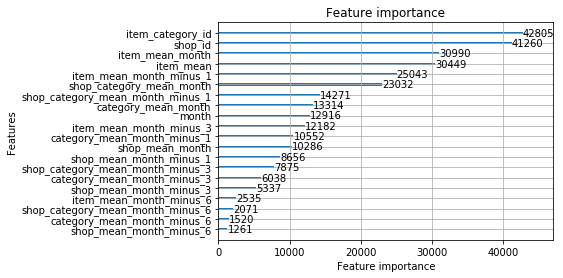

In [35]:
print('Plotting feature importances...')
ax = lgbm.plot_importance(model_lgb, max_num_features=20)
plt.show()

3.45 val > 3.70 submit
3.06 val > 3.65 submit